# Kr analysis (run 3575)

In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import numpy as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Wed Apr  5 22:01:21 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (41.5/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*f.values[1:], *reso(f.values)))

def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

def load_dst(filename):
    with tb.open_file(filename) as h5:
        return pd.DataFrame.from_records(h5.root.Events.read())

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
ifile = os.path.expandvars("/Users/Gonzalo/github/NEXTdata/Na22/Na22DST.h5")

print("ifile:", ifile)

ifile: /Users/Gonzalo/github/NEXTdata/Na22/Na22DST.h5


# Read data

In [5]:
full = load_dst(ifile)
full.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.491342e+09,0,1,275.0,64.295494,365.038980,486125.0,41.665438,9505.395508,...,654462.5,49.0,168.3375,168337.5,-30.902690,53.909130,62.138318,2.091304,41.113927,58.683844
1,4,1.491342e+09,0,1,200.0,36.470367,194.114036,531950.0,23.402500,9115.522461,...,661462.5,27.0,129.5125,129512.5,57.252296,0.689844,57.256452,0.012049,12.112382,52.490100
2,6,1.491342e+09,0,1,225.0,49.535275,273.186763,504150.0,30.916812,9145.306641,...,665462.5,43.0,161.3125,161312.5,-80.515359,8.131453,80.924926,3.040941,20.215411,13.245800
3,8,1.491342e+09,0,1,200.0,35.185417,195.103758,517600.0,29.096375,9989.318359,...,654862.5,22.0,137.2625,137262.5,72.665855,68.384014,99.783264,0.755051,13.088289,22.880939
4,12,1.491342e+09,0,1,175.0,34.424568,179.909183,617450.0,39.079687,20055.962891,...,656412.5,50.0,38.9625,38962.5,79.846011,-0.266283,79.846455,-0.003335,12.658441,19.831387


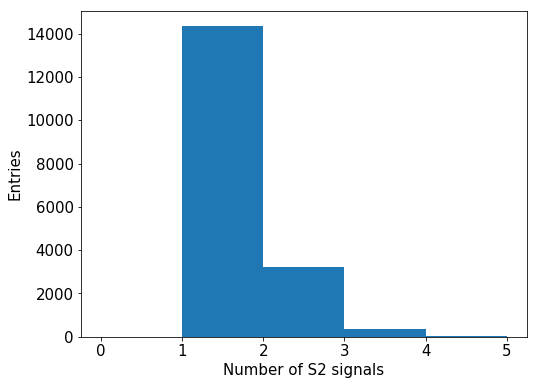

In [6]:
hist(full.nS2, 5, (0,5))
labels("Number of S2 signals", "Entries")

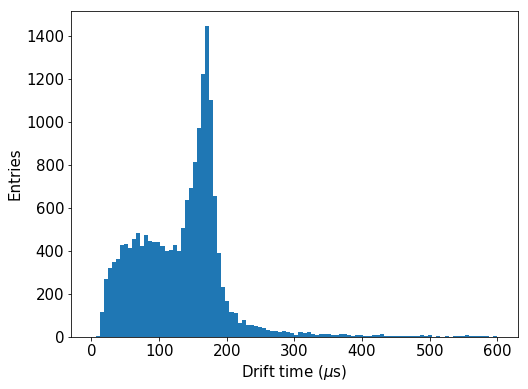

In [15]:
hist(full.Z * 1e-3, 100, (0,600))
labels("Drift time ($\mu$s)", "Entries")

In [20]:
7000/41.5*511

86192.77108433735

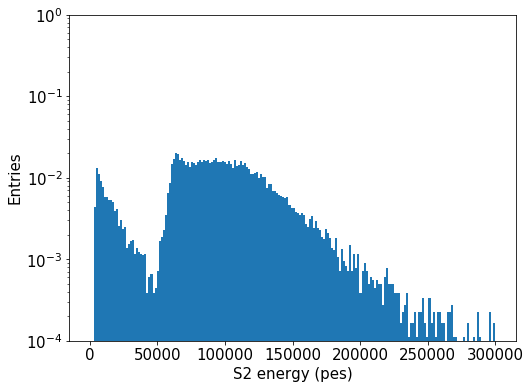

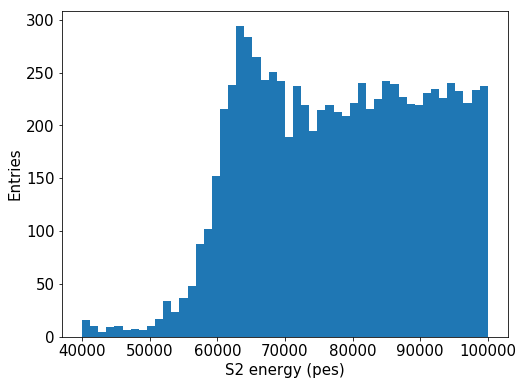

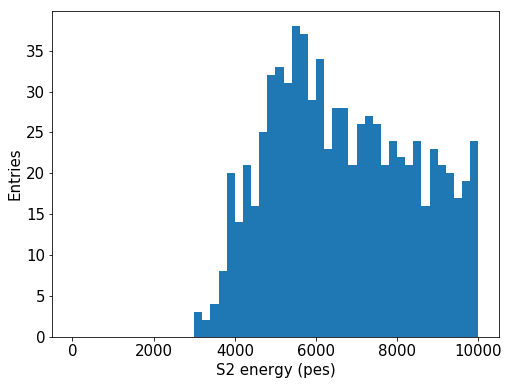

In [22]:
pdf(full.S2e, 200, (0,3e5))
labels("S2 energy (pes)", "Entries")

hist(full.S2e, 50, (40e3,1e5))
labels("S2 energy (pes)", "Entries")

hist(full.S2e, 50, (0,1e4))
labels("S2 energy (pes)", "Entries")

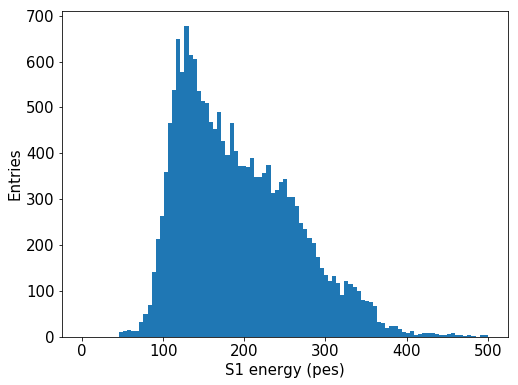

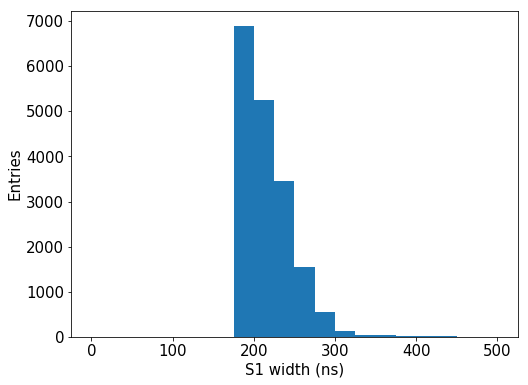

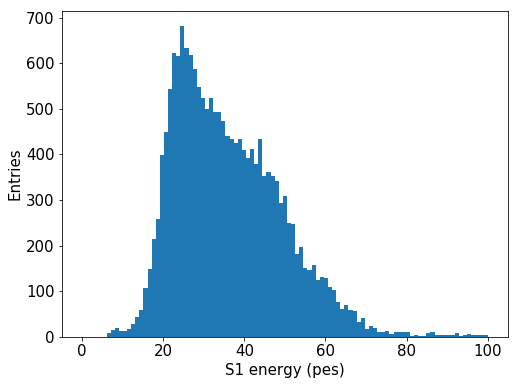

In [8]:
bins = np.linspace(0, 500, 100)
hist(full.S1e, bins)
labels("S1 energy (pes)", "Entries")

bins = np.linspace(0, 500, 21)
hist(full.S1w, bins)
labels("S1 width (ns)", "Entries")

bins = np.linspace(0, 100, 100)
hist(full.S1h, bins)
labels("S1 energy (pes)", "Entries")

# S2 energy vs Z

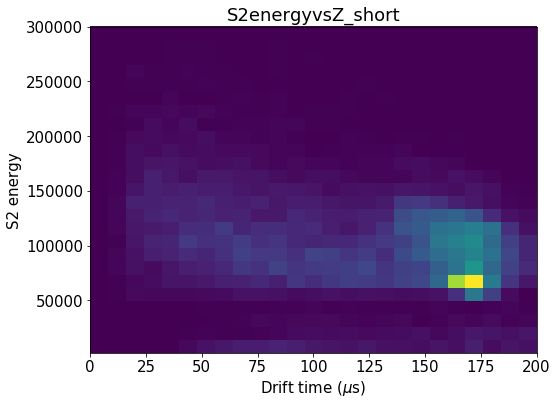

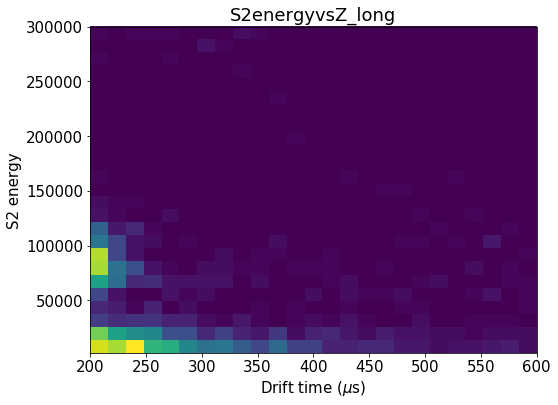

In [41]:
zrange =   0, 200
Erange = 2e3, 3e5
hist2d(full.Z * 1e-3, full.S2e, (25, 25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_short")

zrange = 200, 600
Erange = 2e3, 3e5
hist2d(full.Z * 1e-3, full.S2e, (25,  25), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_long")

# Short drift time: Z < 200 $\mu$s

In [28]:
shortZ = full[full.Z * 1e-3 < 200]
print("Ratio:", len(shortZ)/len(full))
shortZ.head()

Ratio: 0.9257505709352197


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.491342e+09,0,1,275.0,64.295494,365.038980,486125.0,41.665438,9505.395508,...,654462.5,49.0,168.3375,168337.5,-30.902690,53.909130,62.138318,2.091304,41.113927,58.683844
1,4,1.491342e+09,0,1,200.0,36.470367,194.114036,531950.0,23.402500,9115.522461,...,661462.5,27.0,129.5125,129512.5,57.252296,0.689844,57.256452,0.012049,12.112382,52.490100
2,6,1.491342e+09,0,1,225.0,49.535275,273.186763,504150.0,30.916812,9145.306641,...,665462.5,43.0,161.3125,161312.5,-80.515359,8.131453,80.924926,3.040941,20.215411,13.245800
3,8,1.491342e+09,0,1,200.0,35.185417,195.103758,517600.0,29.096375,9989.318359,...,654862.5,22.0,137.2625,137262.5,72.665855,68.384014,99.783264,0.755051,13.088289,22.880939
4,12,1.491342e+09,0,1,175.0,34.424568,179.909183,617450.0,39.079687,20055.962891,...,656412.5,50.0,38.9625,38962.5,79.846011,-0.266283,79.846455,-0.003335,12.658441,19.831387


# S1 energy

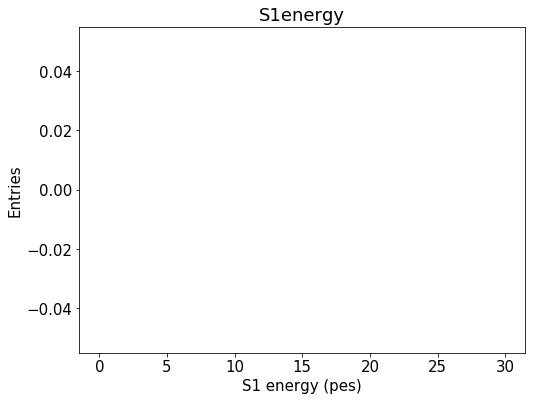

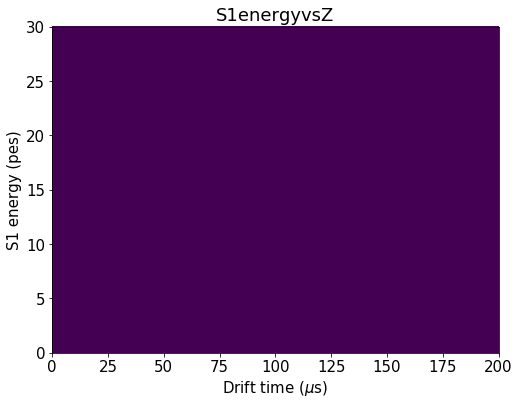

In [29]:
zrange = 0, 200
Srange = 0, 30

hist(shortZ.S1e, 30, range=Srange)
labels("S1 energy (pes)", "Entries")
save("S1energy")

hist2d(shortZ.Z, shortZ.S1e, (50, 30), range=(zrange, Srange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1e, 30, xrange=zrange, yrange=Srange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

# S1 width

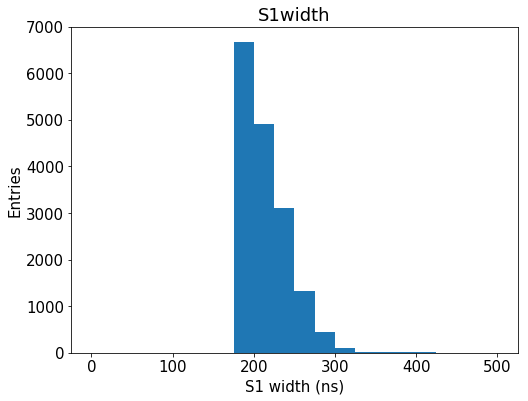

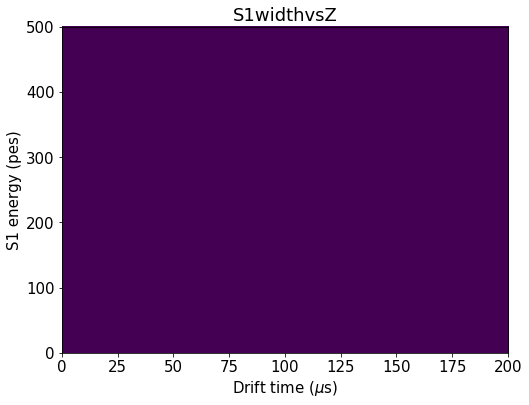

In [30]:
zrange = 0, 200
wrange = 0, 500

hist(shortZ.S1w, np.linspace(*wrange, 21))
labels("S1 width (ns)", "Entries")
save("S1width")

hist2d(shortZ.Z, shortZ.S1w, (50, 21), range=(zrange, wrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1w, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1widthvsZ")

# S1 height

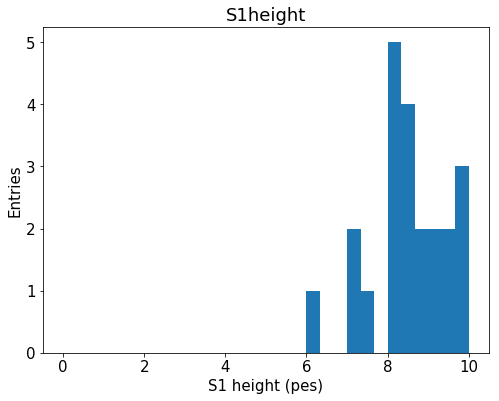

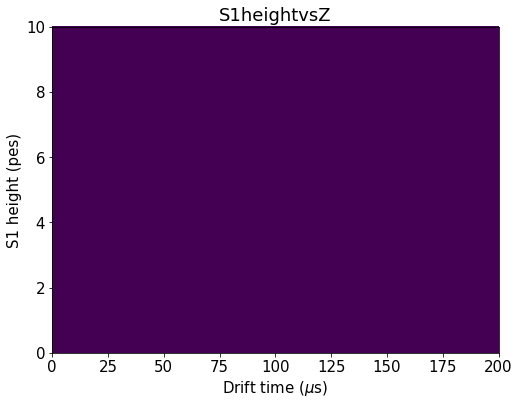

In [31]:
zrange = 0, 200
hrange = 0, 10

hist(shortZ.S1h, 30, range=hrange)
labels("S1 height (pes)", "Entries")
save("S1height")

hist2d(shortZ.Z, shortZ.S1h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

# S1 peak to area ratio

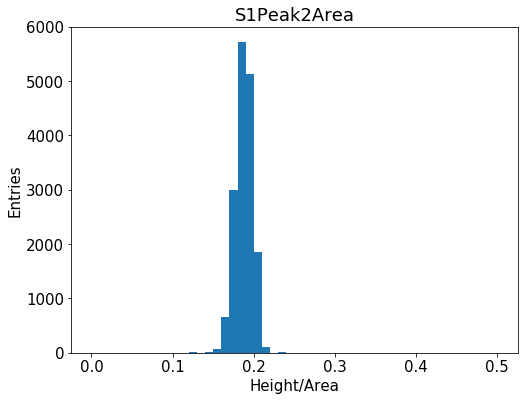

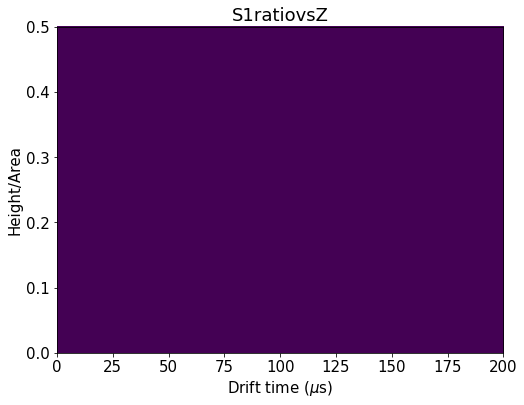

In [32]:
zrange = 0, 200
rrange = 0, 0.5

S1r = shortZ.S1h/shortZ.S1e
hist(S1r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S1Peak2Area")

hist2d(shortZ.Z, S1r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(shortZ.Z, S1r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S1ratiovsZ")

# S2 energy

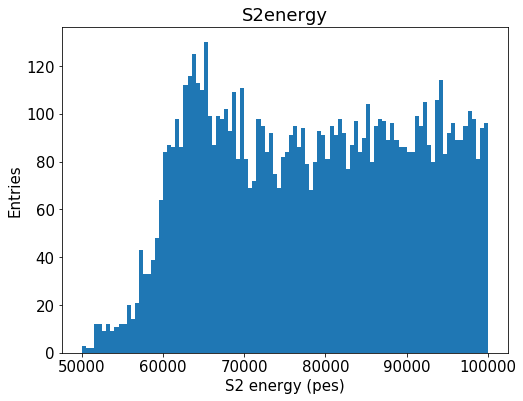

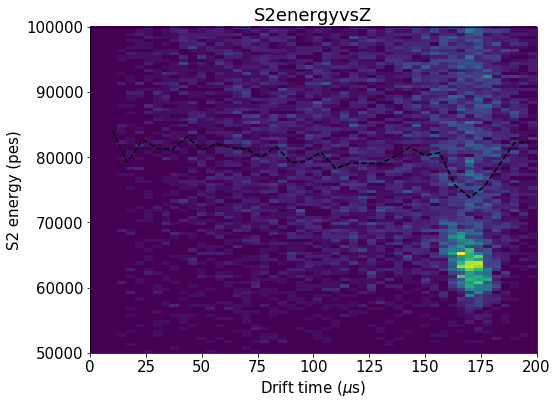

In [45]:
zrange = 0, 200
Erange = 50e3, 100e3

hist(shortZ.S2e, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy")

hist2d(shortZ.Z * 1e-3, shortZ.S2e, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z * 1e-3, shortZ.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

# S2 width

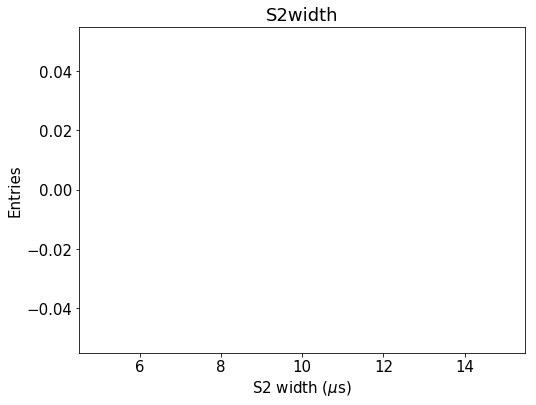

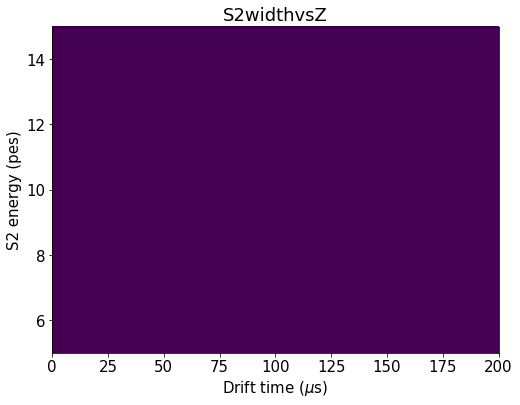

In [46]:
zrange = 0, 200
wrange = 5, 15

hist(shortZ.S2w*1e-3, 20, range=wrange)
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

hist2d(shortZ.Z, shortZ.S2w*1e-3, (50, 20), range=(zrange, wrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2w*1e-3, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2widthvsZ")

# S2 height

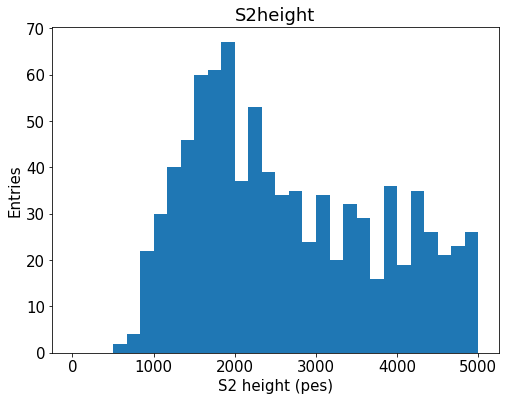

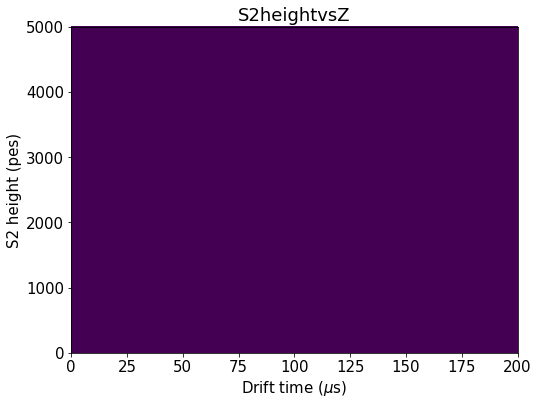

In [47]:
zrange = 0, 200
hrange = 0, 5e3

hist(shortZ.S2h, 30, range=hrange)
labels("S2 height (pes)", "Entries")
save("S2height")

hist2d(shortZ.Z, shortZ.S2h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

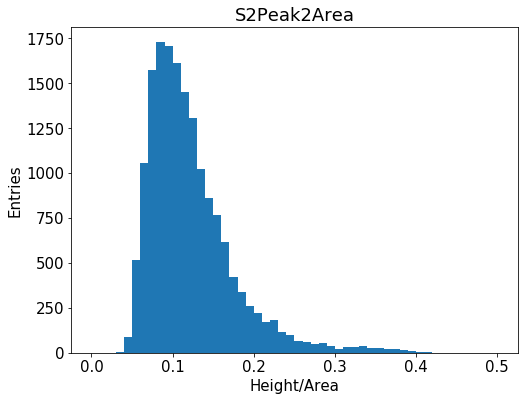

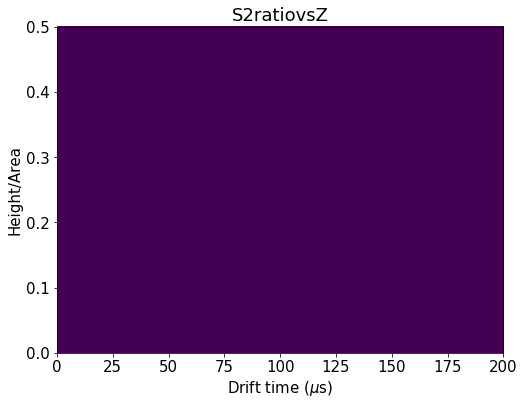

In [48]:
zrange = 0, 200
rrange = 0, 0.5

S2r = shortZ.S2h/shortZ.S2e

hist(S2r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S2Peak2Area")

hist2d(shortZ.Z, S2r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(shortZ.Z, S2r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S2ratiovsZ")

# S2 vs S1

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


LinAlgError: Array must not contain infs or NaNs

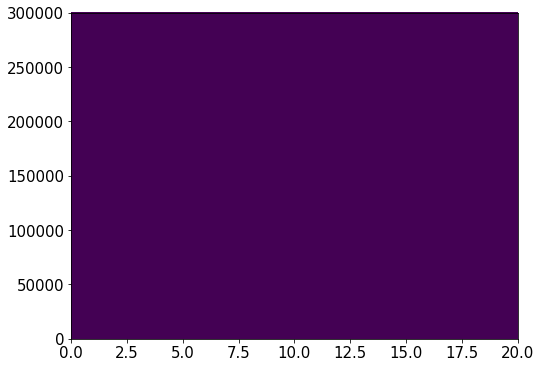

In [50]:
Srange = 0, 20
Erange = 0, 3e5

S = shortZ.S1e
E = shortZ.S2e

hist2d(S, E, (50, 50), range=(Srange, Erange))
x, y, _ = fitf.profileX(S, E, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)

sel = fitf.in_range(S, *Srange) & fitf.in_range(E, *Erange)
c = covariance(S[sel], E[sel])
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

In [ ]:
zrange = 0, 200
Rrange = 0, 0.006

S12r = shortZ.S1e/shortZ.S2e

hist(S12r, 50, range=Rrange)
labels("S1/S2", "Entries")
save("S12ratio")

hist2d(shortZ.Z, S12r, (50, 50), range=(zrange, Rrange))
x, y, _ = fitf.profileX(shortZ.Z, S12r, 30, xrange=zrange, yrange=Rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2")
save("S12ratiovsZ")

# Temporary fiducialization

In [51]:
shortZfid = shortZ[shortZ.R < 100]
print("Ratio:", len(shortZfid)/len(full))
print("Ratio:", len(shortZfid)/len(shortZ))
shortZfid.head()

Ratio: 0.43675151785216954
Ratio: 0.4717809867629362


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.491342e+09,0,1,275.0,64.295494,365.038980,486125.0,41.665438,9505.395508,...,654462.5,49.0,168.3375,168337.5,-30.902690,53.909130,62.138318,2.091304,41.113927,58.683844
1,4,1.491342e+09,0,1,200.0,36.470367,194.114036,531950.0,23.402500,9115.522461,...,661462.5,27.0,129.5125,129512.5,57.252296,0.689844,57.256452,0.012049,12.112382,52.490100
2,6,1.491342e+09,0,1,225.0,49.535275,273.186763,504150.0,30.916812,9145.306641,...,665462.5,43.0,161.3125,161312.5,-80.515359,8.131453,80.924926,3.040941,20.215411,13.245800
3,8,1.491342e+09,0,1,200.0,35.185417,195.103758,517600.0,29.096375,9989.318359,...,654862.5,22.0,137.2625,137262.5,72.665855,68.384014,99.783264,0.755051,13.088289,22.880939
4,12,1.491342e+09,0,1,175.0,34.424568,179.909183,617450.0,39.079687,20055.962891,...,656412.5,50.0,38.9625,38962.5,79.846011,-0.266283,79.846455,-0.003335,12.658441,19.831387


# S2 energy fiducialized

[ 109370.10481656    -316.19750368]


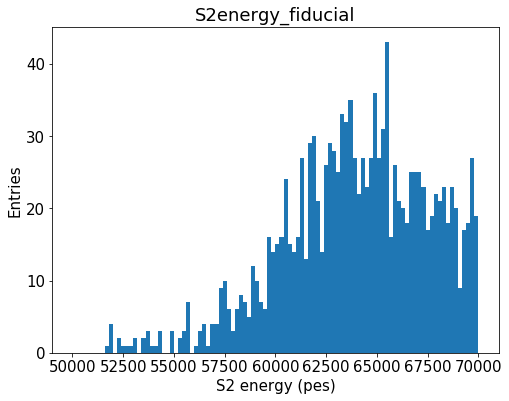

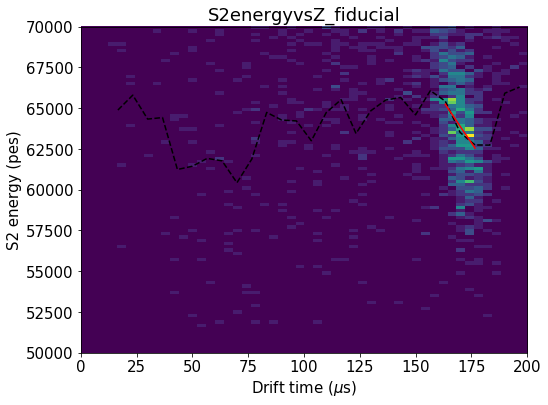

In [56]:
zrange = 0, 200
Erange = 50e3, 70e3

hist(shortZfid.S2e, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy_fiducial")

hist2d(shortZfid.Z * 1e-3, shortZfid.S2e, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZfid.Z * 1e-3, shortZfid.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 160, 180)
x, y = x[sel], y[sel]

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ_fiducial")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

# Correction by attachment

TypeError: Improper input: N=2 must not exceed M=0

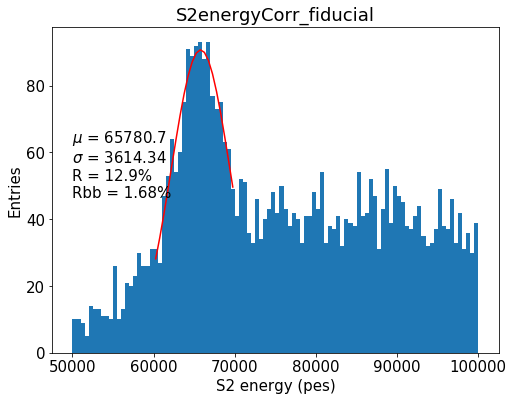

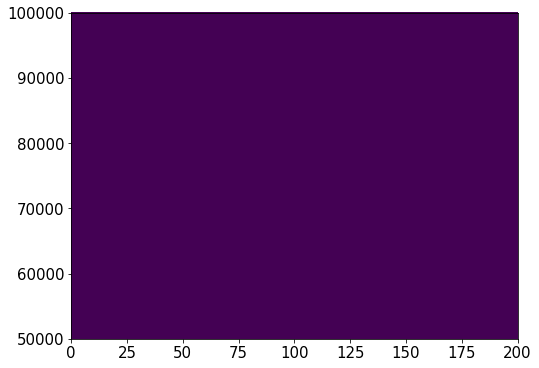

In [59]:
zrange = 0, 200
Erange = 50e3, 100e3

E = shortZfid.S2e * zcorr(shortZfid.Z * 1e-3)

y, x, _ = hist(E, 100, range=Erange)

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 60e3, 70e3)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (1e3, 7e4, 2000))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("S2 energy (pes)", "Entries")
save("S2energyCorr_fiducial")

hist2d(shortZfid.Z, E, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZfid.Z, E, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

sel  = fitf.in_range(x, 75, 150)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)

print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyCorrvsZ_fiducial")

# Tracking

In [ ]:
nrange = 0, 12
zrange = 0, 600

hist(shortZ.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")
save("Nsipm")

hist2d(shortZ.Z, shortZ.Nsipm, (30, max(nrange)), range=(zrange, nrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.Nsipm, 30, xrange=zrange, yrange=nrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs")
save("NsipmvsZ")


# Event distribution

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(shortZ.X, 50, range=xrange)
labels("x (mm)", "Entries")
save("X")

hist(shortZ.Y, 50, range=yrange)
labels("y (mm)", "Entries")
save("Y")

hist(shortZ.R, 50, range=rrange)
labels("r (mm)", "Entries")
save("R")

hist(shortZ.Phi, 50, range=prange)
labels("$\phi$ (rad)", "Entries")
save("Phi")

nevts, xs, ys, _ = \
hist2d(shortZ.X, shortZ.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

################################
hist2d(shortZ.R, shortZ.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

# Tracking charge

In [ ]:
zrange = 0, 200
Qrange = 0, 500

hist(shortZ.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries")
save("S2charge")

hist2d(shortZ.Z, shortZ.S2q, (50, 100), range=(zrange, Qrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2q, 30, xrange=zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)")
save("S2chargevsZ")

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Qrange =    0, 500

_, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, shortZ.S2q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, shortZ.S2q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(shortZ.R, shortZ.S2q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(shortZ.R, shortZ.S2q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(shortZ.Phi, shortZ.S2q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(shortZ.Phi, shortZ.S2q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


# Energy vs position

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 9e3

E = shortZ.S2e * zcorr(shortZ.Z)

pf, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(shortZ.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(shortZ.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

In [ ]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  4e3, 11e3

E  = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values)

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(shortZ.X, shortZ.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(shortZ.R, shortZ.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(shortZ.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(shortZ.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(shortZ.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


In [ ]:
E = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values)
T = (shortZ.time - np.min(shortZ.time))/60

Erange = 4e3, 11e3
Trange =   0, 1800

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

def get_timecorr(T, E):
    eref = np.max(E)
    def timecorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return timecorr
tcorr = get_timecorr(x, y)

In [ ]:
T = (shortZ.time - np.min(shortZ.time))/60
E = shortZ.S2e * zcorr(shortZ.Z) * xycorr(shortZ.X.values, shortZ.Y.values) * tcorr(T)

Trange =   0, 1800
Erange = 4e3, 11e3

y, x, _ = hist(E, 100, Erange)

x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 1e4, 1e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(Erange[0], max(y)/2, gausstext(f.values))

labels("E (pes)", "Entries")
save("EcorrZXYT")

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")
